# Luminescence Decay Analysis

This notebook analyzes the luminescence decay of vials 1-4 from sample set IV 1-39.
Multiple counts were performed at different times to observe the decay of the signal.

## Methodology

1. Extract count timestamps from each CSV file
2. Calculate when each vial was counted (accounting for 100 min count time per vial)
3. Interpolate background values from blank scan based on tSIE
4. Subtract background from Bq:1 values
5. Plot background-subtracted Bq:1 vs time after sample preparation (T=0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
import os

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Blank Scan Data

In [2]:
# Load the blank scan data to create background curve
blank_file = '../../data/tritium_detection/SLR_BLANK_SCAN.csv'

# Read the blank scan, skipping the header lines
with open(blank_file, 'r') as f:
    lines = f.readlines()
    # Find where the data starts (after "S#,SMPL_ID,...")
    data_start = None
    for i, line in enumerate(lines):
        if line.startswith('S#,SMPL_ID'):
            data_start = i
            break

# Read the data
blank_df = pd.read_csv(blank_file, skiprows=data_start)
print("Blank scan data:")
print(blank_df[['SMPL_ID', 'Bq:1', 'tSIE']])

# Create interpolation function for background vs tSIE
background_interp = interp1d(
    blank_df['tSIE'], 
    blank_df['Bq:1'], 
    kind='linear', 
    fill_value='extrapolate'
)

print(f"\nBackground interpolation function created from {len(blank_df)} blank samples")

Blank scan data:
    SMPL_ID   Bq:1    tSIE
0  SLR_BL11  0.306  277.97
1  SLR_BL10  0.266  293.79
2   SLR_BL9  0.263  307.31
3   SLR_BL8  0.237  324.41
4   SLR_BL6  0.205  364.72
5   SLR_BL4  0.181  420.38
6   SLR_BL2  0.170  488.69

Background interpolation function created from 7 blank samples


## 2. Load Count Data and Extract Timestamps

In [3]:
def load_count_data(filepath):
    """
    Load count data from CSV file.
    Returns: dataframe
    """
    # Read the data
    with open(filepath, 'r') as f:
        lines = f.readlines()
        # Find where the data starts
        data_start = None
        for i, line in enumerate(lines):
            if line.startswith('S#,SMPL_ID'):
                data_start = i
                break
    
    df = pd.read_csv(filepath, skiprows=data_start)
    
    return df

# Load all count files with manually specified timestamps
count_files_and_times = [
    ('../../data/tritium_detection/lum_decay_scan/1L-FLB_IV_1-39_CNT_1.csv', '20260113_1822'),
    ('../../data/tritium_detection/lum_decay_scan/1L-FLB_IV_1-39_CNT_2.csv', '20260114_1442'),
    ('../../data/tritium_detection/lum_decay_scan/1L-FLB_IV_1-39_CNT_3.csv', '20260115_1747'),
    ('../../data/tritium_detection/lum_decay_scan/1L-FLB_IV_1-39_CNT_4.csv', '20260116_1213')
]

counts_data = []
for i, (filepath, timestamp_str) in enumerate(count_files_and_times, 1):
    # Parse timestamp: YYYYMMDD_HHMM
    timestamp = datetime.strptime(timestamp_str, '%Y%m%d_%H%M')
    df = load_count_data(filepath)
    
    print(f"Count {i}: Started at {timestamp}")
    print(f"  Loaded {len(df)} rows from file")
    print(f"  Sample IDs: {df['SMPL_ID'].tolist()}")
    print()
    
    counts_data.append({
        'count_number': i,
        'filepath': filepath,
        'start_time': timestamp,
        'data': df
    })

# T=0 is defined as the start time of CNT_1
t_zero = counts_data[0]['start_time']
print(f"T=0 (sample preparation time): {t_zero}")

Count 1: Started at 2026-01-13 18:22:00
  Loaded 4 rows from file
  Sample IDs: ['1L-FLB-IV_1-39-1', '1L-FLB-IV_1-39-2', '1L-FLB-IV_1-39-3', '1L-FLB-IV_1-39-4']

Count 2: Started at 2026-01-14 14:42:00
  Loaded 4 rows from file
  Sample IDs: ['1L-FLB-IV_1-39-1', '1L-FLB-IV_1-39-2', '1L-FLB-IV_1-39-3', '1L-FLB-IV_1-39-4']

Count 3: Started at 2026-01-15 17:47:00
  Loaded 4 rows from file
  Sample IDs: ['1L-FLB-IV_1-39-1', '1L-FLB-IV_1-39-2', '1L-FLB-IV_1-39-3', '1L-FLB-IV_1-39-4']

Count 4: Started at 2026-01-16 12:13:00
  Loaded 4 rows from file
  Sample IDs: ['1L-FLB-IV_1-39-1', '1L-FLB-IV_1-39-2', '1L-FLB-IV_1-39-3', '1L-FLB-IV_1-39-4']

T=0 (sample preparation time): 2026-01-13 18:22:00


## 3. Process Each Vial and Calculate Background-Subtracted Values

In [4]:
def calculate_vial_count_time(count_start_time, vial_number):
    """
    Calculate when a specific vial was counted.
    Vial 1 is counted 100 min after count start.
    Each subsequent vial is counted 100 min after the previous one.
    """
    minutes_after_start = 100 * vial_number
    return count_start_time + timedelta(minutes=minutes_after_start)

# Process all vials
vial_results = {1: [], 2: [], 3: [], 4: []}

print("Timing verification for first count:")
print(f"Count 1 starts at: {counts_data[0]['start_time']}")
for v in [1, 2, 3, 4]:
    time = calculate_vial_count_time(counts_data[0]['start_time'], v)
    mins = 100 * v
    print(f"  Vial {v} counted at: {time} (T+{mins} min)")
print()

print(f"Processing {len(counts_data)} counts for {len([1, 2, 3, 4])} vials each...")
print(f"Expected: {len(counts_data)} data points per vial\n")

for count_info in counts_data:
    count_num = count_info['count_number']
    count_start = count_info['start_time']
    df = count_info['data']
    
    print(f"Processing Count {count_num} (started {count_start})...")
    print(f"  DataFrame S# column: {df['S#'].tolist()}")
    print(f"  DataFrame S# dtype: {df['S#'].dtype}")
    
    # Process each vial (S# 1-4 correspond to vials 1-4)
    for vial_num in [1, 2, 3, 4]:
        # Find the row for this vial
        vial_row = df[df['S#'] == vial_num]
        
        print(f"  Looking for S#={vial_num}, found {len(vial_row)} rows")
        
        if len(vial_row) > 0:
            vial_row = vial_row.iloc[0]
            
            # Get measured values
            bq_measured = vial_row['Bq:1']
            tSIE = vial_row['tSIE']
            
            # Calculate background from interpolation
            background = background_interp(tSIE)
            
            # Background-subtracted value
            bq_corrected = bq_measured - background
            
            # Calculate when this vial was counted
            vial_count_time = calculate_vial_count_time(count_start, vial_num)
            
            # Time after T=0 in days
            time_after_t0 = (vial_count_time - t_zero).total_seconds() / (24 * 3600)
            
            vial_results[vial_num].append({
                'count_number': count_num,
                'count_time': vial_count_time,
                'time_after_t0_days': time_after_t0,
                'bq_measured': bq_measured,
                'tSIE': tSIE,
                'background': background,
                'bq_corrected': bq_corrected
            })
            
            print(f"    -> Bq={bq_measured:.3f}, Bg={background:.3f}, Corrected={bq_corrected:.3f}, t={time_after_t0:.3f} days")
    print()

print(f"\nData points collected per vial:")
for vial_num in [1, 2, 3, 4]:
    print(f"  Vial {vial_num}: {len(vial_results[vial_num])} points")

# Display results in table format
print("\n" + "="*100)
print("BACKGROUND-SUBTRACTED RESULTS")
print("="*100)

for vial_num in [1, 2, 3, 4]:
    print(f"\n--- Vial {vial_num} ---")
    results_df = pd.DataFrame(vial_results[vial_num])
    print(results_df[['count_number', 'time_after_t0_days', 'bq_measured', 'tSIE', 'background', 'bq_corrected']].to_string(index=False))

Timing verification for first count:
Count 1 starts at: 2026-01-13 18:22:00
  Vial 1 counted at: 2026-01-13 20:02:00 (T+100 min)
  Vial 2 counted at: 2026-01-13 21:42:00 (T+200 min)
  Vial 3 counted at: 2026-01-13 23:22:00 (T+300 min)
  Vial 4 counted at: 2026-01-14 01:02:00 (T+400 min)

Processing 4 counts for 4 vials each...
Expected: 4 data points per vial

Processing Count 1 (started 2026-01-13 18:22:00)...
  DataFrame S# column: [1, 2, 3, 4]
  DataFrame S# dtype: int64
  Looking for S#=1, found 1 rows
    -> Bq=0.292, Bg=0.231, Corrected=0.061, t=0.069 days
  Looking for S#=2, found 1 rows
    -> Bq=0.359, Bg=0.266, Corrected=0.093, t=0.139 days
  Looking for S#=3, found 1 rows
    -> Bq=0.284, Bg=0.234, Corrected=0.050, t=0.208 days
  Looking for S#=4, found 1 rows
    -> Bq=0.341, Bg=0.266, Corrected=0.075, t=0.278 days

Processing Count 2 (started 2026-01-14 14:42:00)...
  DataFrame S# column: [1, 2, 3, 4]
  DataFrame S# dtype: int64
  Looking for S#=1, found 1 rows
    -> Bq=0

## 4. Plot Luminescence Decay for All Vials

Vial 1: 4 points at times: ['0.069', '0.917', '2.045', '2.813']
Vial 2: 4 points at times: ['0.139', '0.986', '2.115', '2.883']
Vial 3: 4 points at times: ['0.208', '1.056', '2.184', '2.952']
Vial 4: 4 points at times: ['0.278', '1.125', '2.253', '3.022']


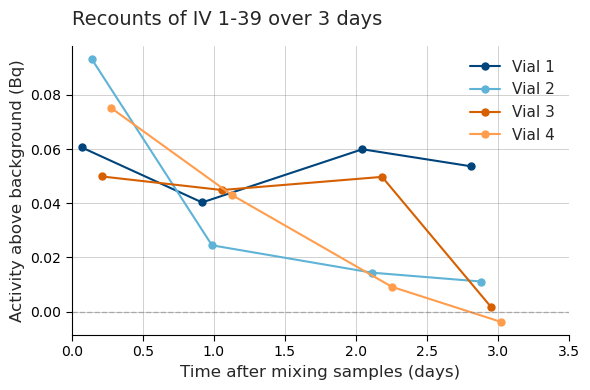


Plot saved to: outputs/luminescence_decay_all_vials.png


In [11]:
# Create figure with all vials
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Colors matching the bar chart reference
# Vial 1: dark blue, Vial 2: light blue, Vial 3: dark orange, Vial 4: light orange
colors = ['#00447c', '#5eb3d6', '#d65f00', '#ff9d4d']
markers = ['o', 'o', 'o', 'o']  # All circles

for vial_num in [1, 2, 3, 4]:
    results = vial_results[vial_num]
    times = [r['time_after_t0_days'] for r in results]
    bq_values = [r['bq_corrected'] for r in results]
    
    print(f"Vial {vial_num}: {len(times)} points at times: {[f'{t:.3f}' for t in times]}")
    
    ax.plot(times, bq_values, 
            marker=markers[vial_num-1], 
            color=colors[vial_num-1],
            linewidth=1.5, 
            markersize=5,
            label=f'Vial {vial_num}',
            linestyle='-')

ax.set_xlabel('Time after mixing samples (days)', fontsize=12)
ax.set_ylabel('Activity above background (Bq)', fontsize=12)
ax.set_title('Recounts of IV 1-39 over 3 days', loc='left', fontsize=14, pad=15)
ax.legend(fontsize=11, loc='best')

# Gray solid gridlines
ax.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Show only left and bottom spines
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Black axis ticks - show major ticks
ax.tick_params(axis='both', which='major', colors='black', direction='out', 
               length=4, width=0.8, labelsize=10)

# Add horizontal line at zero for reference
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Set axis limits
ax.set_xlim(left=0, right=3.5)

plt.tight_layout()
plt.savefig('outputs/luminescence_decay_all_vials.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: outputs/luminescence_decay_all_vials.png")

## 5. Individual Vial Plots

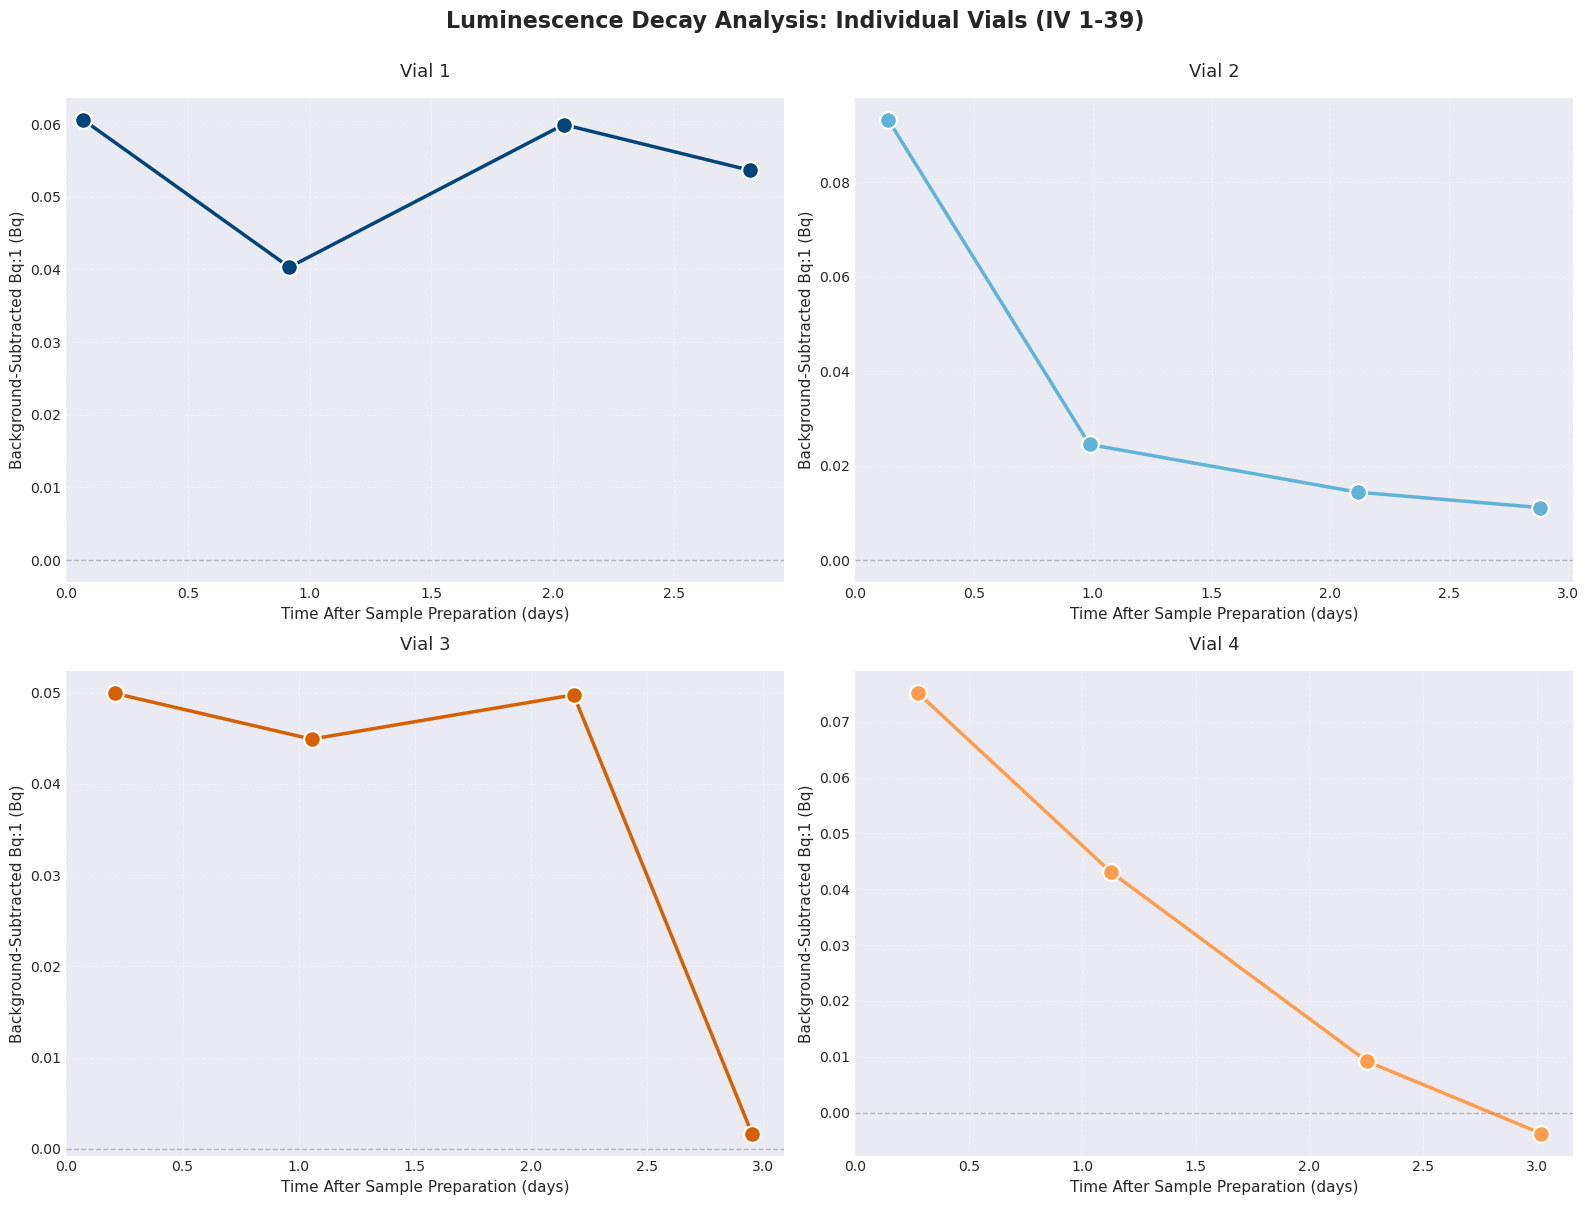


Plot saved to: outputs/luminescence_decay_individual_vials.png


In [6]:
# Create individual plots for each vial
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, vial_num in enumerate([1, 2, 3, 4]):
    ax = axes[idx]
    results = vial_results[vial_num]
    times = [r['time_after_t0_days'] for r in results]
    bq_values = [r['bq_corrected'] for r in results]
    
    ax.plot(times, bq_values, 
            marker=markers[idx], 
            color=colors[idx],
            linewidth=2.5, 
            markersize=12,
            linestyle='-',
            alpha=1.0,
            markeredgewidth=1.5,
            markeredgecolor='white')
    
    ax.set_xlabel('Time After Sample Preparation (days)', fontsize=11)
    ax.set_ylabel('Background-Subtracted Bq:1 (Bq)', fontsize=11)
    ax.set_title(f'Vial {vial_num}', fontsize=13, pad=15)
    ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Set x-axis to start at 0 to show all data points
    ax.set_xlim(left=0)

plt.suptitle('Luminescence Decay Analysis: Individual Vials (IV 1-39)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('outputs/luminescence_decay_individual_vials.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: outputs/luminescence_decay_individual_vials.png")

## 6. Summary Statistics

In [7]:
# Calculate decay statistics for each vial
print("\n" + "="*100)
print("DECAY STATISTICS")
print("="*100)

for vial_num in [1, 2, 3, 4]:
    results = vial_results[vial_num]
    bq_values = [r['bq_corrected'] for r in results]
    times = [r['time_after_t0_days'] for r in results]
    
    initial_bq = bq_values[0]
    final_bq = bq_values[-1]
    total_change = final_bq - initial_bq
    percent_change = (total_change / initial_bq * 100) if initial_bq != 0 else 0
    time_span = times[-1] - times[0]
    
    print(f"\nVial {vial_num}:")
    print(f"  Initial Bq (corrected): {initial_bq:.4f} Bq at t={times[0]:.3f} days")
    print(f"  Final Bq (corrected):   {final_bq:.4f} Bq at t={times[-1]:.3f} days")
    print(f"  Total change:           {total_change:.4f} Bq ({percent_change:+.2f}%)")
    print(f"  Time span:              {time_span:.3f} days")
    print(f"  Average rate:           {total_change/time_span:.4f} Bq/day")


DECAY STATISTICS

Vial 1:
  Initial Bq (corrected): 0.0606 Bq at t=0.069 days
  Final Bq (corrected):   0.0536 Bq at t=2.813 days
  Total change:           -0.0070 Bq (-11.49%)
  Time span:              2.744 days
  Average rate:           -0.0025 Bq/day

Vial 2:
  Initial Bq (corrected): 0.0933 Bq at t=0.139 days
  Final Bq (corrected):   0.0111 Bq at t=2.883 days
  Total change:           -0.0821 Bq (-88.08%)
  Time span:              2.744 days
  Average rate:           -0.0299 Bq/day

Vial 3:
  Initial Bq (corrected): 0.0499 Bq at t=0.208 days
  Final Bq (corrected):   0.0017 Bq at t=2.952 days
  Total change:           -0.0482 Bq (-96.63%)
  Time span:              2.744 days
  Average rate:           -0.0176 Bq/day

Vial 4:
  Initial Bq (corrected): 0.0751 Bq at t=0.278 days
  Final Bq (corrected):   -0.0038 Bq at t=3.022 days
  Total change:           -0.0789 Bq (-105.02%)
  Time span:              2.744 days
  Average rate:           -0.0287 Bq/day


## 7. Export Results to CSV

In [8]:
# Combine all results into a single dataframe for export
all_results = []
for vial_num in [1, 2, 3, 4]:
    for result in vial_results[vial_num]:
        all_results.append({
            'vial_number': vial_num,
            'count_number': result['count_number'],
            'count_time': result['count_time'],
            'time_after_t0_days': result['time_after_t0_days'],
            'bq_measured': result['bq_measured'],
            'tSIE': result['tSIE'],
            'background': result['background'],
            'bq_corrected': result['bq_corrected']
        })

results_export_df = pd.DataFrame(all_results)
output_file = 'outputs/luminescence_decay_results.csv'
results_export_df.to_csv(output_file, index=False)

print(f"\nResults exported to: {output_file}")
print("\nFirst few rows:")
print(results_export_df.head(10))


Results exported to: outputs/luminescence_decay_results.csv

First few rows:
   vial_number  count_number          count_time  time_after_t0_days  \
0            1             1 2026-01-13 20:02:00            0.069444   
1            1             2 2026-01-14 16:22:00            0.916667   
2            1             3 2026-01-15 19:27:00            2.045139   
3            1             4 2026-01-16 13:53:00            2.813194   
4            2             1 2026-01-13 21:42:00            0.138889   
5            2             2 2026-01-14 18:02:00            0.986111   
6            2             3 2026-01-15 21:07:00            2.114583   
7            2             4 2026-01-16 15:33:00            2.882639   
8            3             1 2026-01-13 23:22:00            0.208333   
9            3             2 2026-01-14 19:42:00            1.055556   

   bq_measured    tSIE           background  bq_corrected  
0        0.292  331.45   0.2314113123294468      0.060589  
1        